# Control hubs
- Control hubs are identified using the baseline control group's connectomes.
- Classify Control hubs as nodes with average controllability greater than 1 std.dev above the mean average controllability for all nodes in the control BL participants.
- After identifying the control hubs, investigate how the ctrb. value/rank of these nodes changed longitudinally and cross-sectionally

In [1]:
import math

import networkx as nx
import pandas as pd
import numpy as np
import importlib
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
print(sys.version)

import Towlson_group_code.data_io as myFunc
importlib.reload(myFunc)

import PREVENT_functions as prev_fct
importlib.reload(prev_fct)

PICKLE_PATH = '../../PREVENT_Study/pickles/'
FIGURE_PATH = '../../PREVENT_Study/figures/'
DUMP_PATH = '../../PREVENT_Study/dump/'
TIMES = ['BL', 'Y1', 'Y3', 'Y5']
metadata, node_list = prev_fct.load_meta_data()
print(len(node_list))
individual_data = myFunc.load_from_pickle(PICKLE_PATH, 'Normalized_Connectomes.pkl')

color_map = {"BL": '#1f77b4', "Y1": '#ff7f0e', "Y3": '#2ca02c', "Y5": '#d62728'}

3.8.12 (default, Mar  1 2023, 16:37:51) 
[Clang 13.1.6 (clang-1316.0.21.2.5)]
150


In [2]:
def getControlHubs(sample_G, metric):
    """
    Calculates the control hubs of a network G. Control hubs are nodes with ctrb. value greater than 1 stddev. above the mean nodal controllability of the sample set.
    sample_G: The set of networks, as a list of NetworkX graph object
    Metric: 'avgCtrb' or 'modCtrb', string
    Returns the number of control hubs and the control hubs node labels
    """
    ctrb = []
    node_list = list(sample_G[0])
    for G in sample_G:
        ctrb.append(list(nx.get_node_attributes(G, metric).values()))
    mean_ctrb_across_participants = np.average(np.array(ctrb), axis=0)
    mean_ctrb_value = np.average(mean_ctrb_across_participants)
    stddev = np.std(mean_ctrb_across_participants)
    control_hub_mask = mean_ctrb_across_participants > (mean_ctrb_value + stddev)

    if ((control_hub_mask==0) | (control_hub_mask==1)).all():
        print("mask is boolean, with sum = ", sum(control_hub_mask))

        control_hubs = {}
        for i in np.where(control_hub_mask == True)[0]:
            control_hubs[i] = node_list[i]

        return sum(control_hub_mask), control_hubs

    print("Error.")
    return 0, []

## Average Control Hubs

In [3]:
n_avg, avg_ctrb_hubs = getControlHubs(list(individual_data['HCbl'].values()), 'avgCtrb')
print(list(avg_ctrb_hubs.keys()))
print(*list(avg_ctrb_hubs.values()), sep="\n")

mask is boolean, with sum =  17
[13, 29, 30, 39, 52, 54, 55, 56, 67, 68, 76, 81, 102, 128, 140, 141, 149]
ctx_lh_G_and_S_occipital_inf
ctx_lh_G_occipital_middle
ctx_lh_G_occipital_sup
ctx_lh_G_precentral
ctx_lh_Pole_occipital
ctx_lh_S_calcarine
ctx_lh_S_central
ctx_lh_S_cingul-Marginalis
ctx_lh_S_oc_middle_and_Lunatus
ctx_lh_S_oc_sup_and_transversal
ctx_lh_S_pericallosal
ctx_lh_S_subparietal
ctx_rh_G_occipital_middle
ctx_rh_S_central
ctx_rh_S_oc_middle_and_Lunatus
ctx_rh_S_oc_sup_and_transversal
ctx_rh_S_pericallosal


For each of the identified control hubs, how does their ctrb. value change between control vs tia at different time points?

In [4]:
age_years_map = {'BL': 0, 'Y1': 1, 'Y3': 3, 'Y5': 5}
avg_control_hubs_result_df = pd.DataFrame(data={'Node Id': [],
                               'PID': [],
                               'Time': [],
                                'Age': [],
                               'C/T': [],
                               'Average Ctrb.': [],
                               'Average Ctrb. Rank': []})
metric = "avgCtrb"
hub_label_list = list(avg_ctrb_hubs.values())
hub_list = [str(i) for i in list(avg_ctrb_hubs.keys())]
for k, data in individual_data.items():
    CT = ""
    time = ""
    if "HC" in k:
        CT = "Control"
        time = k[2:]
    else:
        CT = "TIA"
        time = k[1:]
    time = time.upper()
    for pid, G in data.items():
        _, ranked_G, _ = prev_fct.rank_nodes(G, metric)

        ctrb = [G.nodes[node][metric] for node in hub_label_list]
        ctrb_rank = [G.nodes[node][metric + "Rank"] for node in hub_label_list]
        age = metadata.loc[pid]['Age'] + age_years_map[time]

        temp_df = pd.DataFrame(data={'Node Id': hub_list,
                               'PID': [pid]*n_avg,
                               'Time': [time]*n_avg,
                               'C/T': [CT]*n_avg,
                                'Age': [age]*n_avg,
                               'Average Ctrb.': ctrb,
                               'Average Ctrb. Rank': ctrb_rank})

        avg_control_hubs_result_df = pd.concat([avg_control_hubs_result_df, temp_df])

avg_control_hubs_result_df.head(3)

,Node Id,PID,Time,Age,C/T,Average Ctrb.,Average Ctrb. Rank
0,13,118,BL,61.0,Control,1.111680,95.0
1,29,118,BL,61.0,Control,1.075144,74.0
2,30,118,BL,61.0,Control,1.149380,116.0


Cross-sectional comparison of Average Control Hub controllability distribution at each Time point.

| Hub name | Node index | p value | Time |
| - | - | - | - |
| ctx_rh_G_occipital_middle | 102 |  $ p = 0.00044683$ | BL |

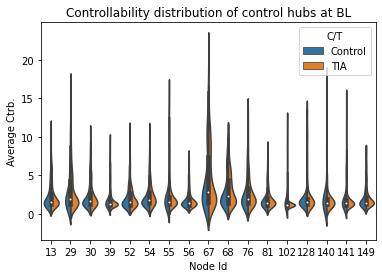

102 ctx_rh_G_occipital_middle 0.0004468374153473478


In [5]:
from scipy.stats import mannwhitneyu

t = "BL"
plot_df = avg_control_hubs_result_df[avg_control_hubs_result_df["Time"] == t]
sns.violinplot(data=plot_df, x="Node Id", y="Average Ctrb.", hue="C/T", split=True)
#sns.boxplot(data=plot_df, x="Node Id", y="Average Ctrb.", hue="C/T")
plt.title("Controllability distribution of control hubs at " + t)
#plt.savefig(FIGURE_PATH+"new analysis/" + f"Avg Ctr Hubs at {t}", dpi=300)
plt.show()

for hub_number, hub_name in avg_ctrb_hubs.items():
    control_subset = plot_df[(plot_df["C/T"] == "Control") & (plot_df["Node Id"] == str(hub_number))]
    tia_subset = plot_df[(plot_df["C/T"] == "TIA") & (plot_df["Node Id"] == str(hub_number))]
    stats, p = mannwhitneyu(control_subset["Average Ctrb."], tia_subset["Average Ctrb."], method='asymptotic', alternative="two-sided")

    if p*n_avg < 0.05:
        print(hub_number, hub_name, p)
        # print("\t", f"HC mean: {} | TIA mean: {}")

Plot distribution comparison for a particular hub node
- If the above showed a node with significance, use code below to plot just that node's distribution comparison.

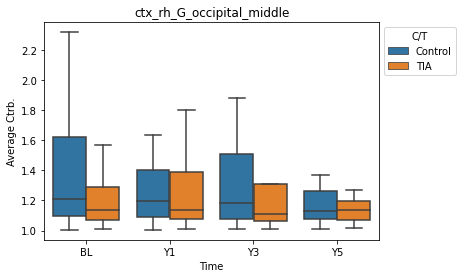

In [13]:
t = "BL"
# plot_df = avg_control_hubs_result_df[(avg_control_hubs_result_df["Time"] == t) & (avg_control_hubs_result_df["Node Id"] == '102')]
plot_df = avg_control_hubs_result_df[(avg_control_hubs_result_df["Node Id"] == '102')]
my_plot = sns.boxplot(data=plot_df, x="Time", y="Average Ctrb.", hue="C/T", showfliers = False)
plt.title(avg_ctrb_hubs[102])
sns.move_legend(my_plot, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(FIGURE_PATH+"new analysis/" + f"Avg Ctr Hub {102}", dpi=250, bbox_inches='tight')
plt.show()

#### Average control hubs - longitudinal analysis
Comparing the average control hubs between their BL distribution to Y5 distribution.

Results:
- Neither groups (control or TIA) had significant changes in avg. control hub ctrb. distribution between BL and Y5

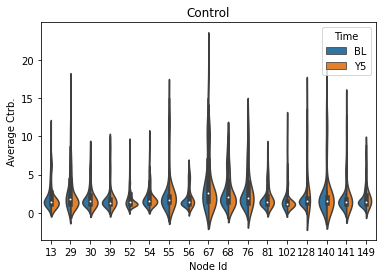

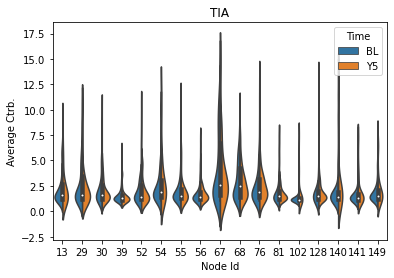

In [16]:
time_group = "Y5"
plot_df = avg_control_hubs_result_df[(avg_control_hubs_result_df["Time"] == 'BL') | (avg_control_hubs_result_df["Time"] == time_group)]
plot_df = plot_df[plot_df["C/T"] == "Control"]
sns.violinplot(data=plot_df, x="Node Id", y="Average Ctrb.", hue="Time", split=True)
plt.title("Control")
# plt.savefig(FIGURE_PATH+"new analysis/" + f"Avg Ctr Hubs at {t}", dpi=300)
plt.show()

for hub_number, hub_name in avg_ctrb_hubs.items():
    bl_subset = plot_df[(plot_df["Time"] == "BL") & (plot_df["Node Id"] == str(hub_number))]
    y5_subset = plot_df[(plot_df["Time"] == time_group) & (plot_df["Node Id"] == str(hub_number))]
    stats, p = mannwhitneyu(bl_subset["Average Ctrb."], y5_subset["Average Ctrb."], method='asymptotic', alternative="two-sided")

    if p*n_avg < 0.05:
        print(hub_number, hub_name, p)

plot_df = avg_control_hubs_result_df[(avg_control_hubs_result_df["Time"] == 'BL') | (avg_control_hubs_result_df["Time"] == time_group)]
plot_df = plot_df[plot_df["C/T"] == "TIA"]
sns.violinplot(data=plot_df, x="Node Id", y="Average Ctrb.", hue="Time", split=True)
plt.title("TIA")
# plt.savefig(FIGURE_PATH+"new analysis/" + f"Avg Ctr Hubs at {t}", dpi=300)
plt.show()

for hub_number, hub_name in avg_ctrb_hubs.items():
    bl_subset = plot_df[(plot_df["Time"] == "BL") & (plot_df["Node Id"] == str(hub_number))]
    y5_subset = plot_df[(plot_df["Time"] == time_group) & (plot_df["Node Id"] == str(hub_number))]
    stats, p = mannwhitneyu(bl_subset["Average Ctrb."], y5_subset["Average Ctrb."], method='asymptotic', alternative="two-sided")

    if p*n_avg < 0.05:
        print(hub_number, hub_name, p)

In [19]:
export_df = avg_control_hubs_result_df[avg_control_hubs_result_df["Node Id"] == "102"]

gender = []
education = []
for pid in export_df["PID"]:
    gender.append(metadata.loc[pid]["Gender"])
    education.append(metadata.loc[pid]["education_yrs"])

export_df["EducationYrs"] = education
export_df["BioSex"] = gender

print(export_df.head(5))
print(len(export_df.index))
export_df = export_df.dropna()
print(len(export_df.index))

export_df = export_df.rename(columns={"Average Ctrb.": "AvgCtrb", "Average Ctrb. Rank": "AvgCtrbRank",
                                      "C/T": "Group",
                                      "Time": "Time",})

export_df.to_csv('../../PREVENT_Study/dump/avg_ctrb_hub_102_aging.csv')

   Node Id  PID Time   Age      C/T  Average Ctrb.  Average Ctrb. Rank  \
12     102  118   BL  61.0  Control       1.167350               121.0   
12     102  103   BL  44.0  Control       2.552857               150.0   
12     102  088   BL  68.0  Control       1.590523               136.0   
12     102  093   BL  63.0  Control       1.097180                89.0   
12     102  213   BL  60.0  Control       1.622900               138.0   

    EducationYrs BioSex  
12          16.0      M  
12          16.0      M  
12          12.0      M  
12          12.0      F  
12          14.0      F  
620
583


/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2910/2244486275.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df["EducationYrs"] = education
/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2910/2244486275.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df["BioSex"] = gender


## Modal Control Hubs

In [6]:
n_mod, mod_ctrb_hubs = getControlHubs(list(individual_data['HCbl'].values()), 'modCtrb')
print(*list(mod_ctrb_hubs.values()), sep="\n")

mask is boolean, with sum =  6
Left-Thalamus
Left-Caudate
Right-Thalamus
Right-Caudate
ctx_lh_G_Ins_lg_and_S_cent_ins
ctx_rh_G_Ins_lg_and_S_cent_ins


For each of the identified control hubs, how does their ctrb. value change between control vs tia at different time points?

In [27]:
modal_control_hubs_result_df = pd.DataFrame(data={'Node Id': [],
                               'PID': [],
                               'Time': [],
                               'C/T': [],
                               'Age': [],
                               'Modal Ctrb.': [],
                               'Modal Ctrb. Rank': []})
metric = "modCtrb"
hub_label_list = list(mod_ctrb_hubs.values())
hub_list = [str(i) for i in list(mod_ctrb_hubs.keys())]
print(len(hub_list))
for k, data in individual_data.items():
    CT = ""
    time = ""
    if "HC" in k:
        CT = "Control"
        time = k[2:]
    else:
        CT = "TIA"
        time = k[1:]
    time = time.upper()
    for pid, G in data.items():
        _, ranked_G, _ = prev_fct.rank_nodes(G, metric)

        ctrb = [G.nodes[node][metric] for node in hub_label_list]
        ctrb_rank = [G.nodes[node][metric + "Rank"] for node in hub_label_list]
        age = metadata.loc[pid]['Age'] + age_years_map[time]

        temp_df = pd.DataFrame(data={'Node Id': hub_list,
                               'PID': [pid]*n_mod,
                               'Time': [time]*n_mod,
                               'C/T': [CT]*n_mod,
                               'Age': [age]*n_mod,
                               'Modal Ctrb.': ctrb,
                               'Modal Ctrb. Rank': ctrb_rank})

        modal_control_hubs_result_df = pd.concat([modal_control_hubs_result_df, temp_df])

6


Modal Control Hub differences between Control vs TIA groups

| Hub name | Hub index | p value | Time |
| - | - | - | - |
| Right-Caudate | 7 |  $ p = 0.00481271$ | BL |
| ctx_rh_G_Ins_lg_and_S_cent_ins | 101 |  $ p = 0.007715$ | BL |

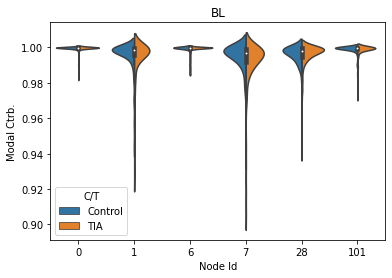

7 Right-Caudate 0.004812707778672518
101 ctx_rh_G_Ins_lg_and_S_cent_ins 0.007715052591459134


In [21]:
t = "BL"
plot_df = modal_control_hubs_result_df[modal_control_hubs_result_df["Time"] == t]
sns.violinplot(data=plot_df, x="Node Id", y="Modal Ctrb.", hue="C/T", split=True)
plt.title(t)
# plt.savefig(FIGURE_PATH+"new analysis/" + f"Modal Ctr Hubs at {t}", dpi=300)
plt.show()

for hub_number, hub_name in mod_ctrb_hubs.items():
    control_subset = plot_df[(plot_df["C/T"] == "Control") & (plot_df["Node Id"] == str(hub_number))]
    tia_subset = plot_df[(plot_df["C/T"] == "TIA") & (plot_df["Node Id"] == str(hub_number))]
    _, p = mannwhitneyu(control_subset["Modal Ctrb."], tia_subset["Modal Ctrb."], method='asymptotic', alternative="two-sided")

    if p*n_mod < 0.05:
        print(hub_number, hub_name, p)

Print specific hub node's distribution

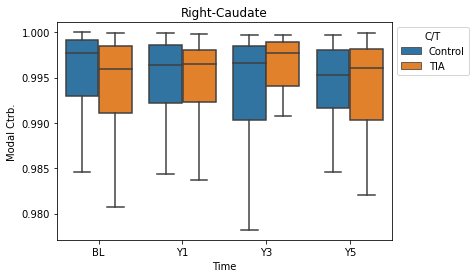

In [22]:
plot_df = modal_control_hubs_result_df[(modal_control_hubs_result_df["Node Id"] == '7')]
my_plot = sns.boxplot(data=plot_df, x="Time", y="Modal Ctrb.", hue="C/T", showfliers = False)
plt.title(mod_ctrb_hubs[7])
sns.move_legend(my_plot, "upper left", bbox_to_anchor=(1, 1))
# plt.savefig(FIGURE_PATH+"new analysis/" + f"Modal Ctr Hub {7}", dpi=250, bbox_inches='tight')
plt.show()

#### Modal control hubs - longitudinal analysis
Comparing the modal control hubs between their BL distribution to Y5 distribution.

Results:
- Neither groups (control or TIA) had significant changes in modal control hubs ctrb. distribution between BL and Y5

In [ ]:
plot_df = modal_control_hubs_result_df[(modal_control_hubs_result_df["Time"] == 'BL') | (modal_control_hubs_result_df["Time"] == 'Y5')]
plot_df = plot_df[plot_df["C/T"] == "Control"]
sns.violinplot(data=plot_df, x="Node Id", y="Modal Ctrb.", hue="Time", split=True)
plt.title("Control")
# plt.savefig(FIGURE_PATH+"new analysis/" + f"Avg Ctr Hubs at {t}", dpi=300)
plt.show()

for hub_number, hub_name in mod_ctrb_hubs.items():
    bl_subset = plot_df[(plot_df["Time"] == "BL") & (plot_df["Node Id"] == str(hub_number))]
    y5_subset = plot_df[(plot_df["Time"] == "Y5") & (plot_df["Node Id"] == str(hub_number))]
    stats, p = mannwhitneyu(bl_subset["Modal Ctrb."], y5_subset["Modal Ctrb."], method='asymptotic', alternative="two-sided")

    if p*n_mod < 0.05:
        print(hub_number, hub_name, p)

plot_df = modal_control_hubs_result_df[(modal_control_hubs_result_df["Time"] == 'BL') | (modal_control_hubs_result_df["Time"] == 'Y5')]
plot_df = plot_df[plot_df["C/T"] == "TIA"]
sns.violinplot(data=plot_df, x="Node Id", y="Modal Ctrb.", hue="Time", split=True)
plt.title("TIA")
# plt.savefig(FIGURE_PATH+"new analysis/" + f"Avg Ctr Hubs at {t}", dpi=300)
plt.show()

for hub_number, hub_name in mod_ctrb_hubs.items():
    bl_subset = plot_df[(plot_df["Time"] == "BL") & (plot_df["Node Id"] == str(hub_number))]
    y5_subset = plot_df[(plot_df["Time"] == "Y5") & (plot_df["Node Id"] == str(hub_number))]
    stats, p = mannwhitneyu(bl_subset["Modal Ctrb."], y5_subset["Modal Ctrb."], method='asymptotic', alternative="two-sided")

    if p*n_mod < 0.05:
        print(hub_number, hub_name, p)

# Longitudinal analysis of Control Hubs
How do hubs change with age?

In [29]:
export_df = modal_control_hubs_result_df[modal_control_hubs_result_df["Node Id"] == "7"]

gender = []
education = []
for pid in export_df["PID"]:
    gender.append(metadata.loc[pid]["Gender"])
    education.append(metadata.loc[pid]["education_yrs"])

export_df["EducationYrs"] = education
export_df["BioSex"] = gender

print(export_df.head(5))
print(len(export_df.index))
export_df = export_df.dropna()
print(len(export_df.index))

export_df = export_df.rename(columns={"Modal Ctrb.": "ModalCtrb",
                                      "Modal Ctrb. Rank": "ModalCtrbRank",
                                      "C/T": "Group"})

export_df.to_csv('../../PREVENT_Study/dump/modal_ctrb_hub_7_aging.csv')


  Node Id  PID Time      C/T   Age  Modal Ctrb.  Modal Ctrb. Rank  \
3       7  118   BL  Control  61.0     0.997139             149.0   
3       7  103   BL  Control  44.0     0.998896             152.0   
3       7  088   BL  Control  68.0     0.999888             155.0   
3       7  093   BL  Control  63.0     0.999295             153.0   
3       7  213   BL  Control  60.0     0.995565             146.0   

   EducationYrs BioSex  
3          16.0      M  
3          16.0      M  
3          12.0      M  
3          12.0      F  
3          14.0      F  
620
583


/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2910/3265236446.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df["EducationYrs"] = education
/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2910/3265236446.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df["BioSex"] = gender
